# Rubin Calibration Flat Field Calibration Exposure Time Calculator - White Light Source

This notebook is used to determine the exposure time needed to complete the flat field calibrations for Rubin using the white light sources (i.e. LEDs).

A further description can be found at https://sitcomtn-049.lsst.io

In [301]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpolate

from scipy.integrate import simps

In [302]:
plt.rc('font', size=14, family='serif')

## System Information

In [303]:
tput_dir = './baseline_tput_curves'
filter_info = {'u':[324,395.0] ,'g': [405,552,],'r':[552,691] ,'i':[691,818] ,'z':[818,921] , 'y4':[922,997] }

outer_diam = 9.27 # [m] 
inner_diam = 4.18 # [m]
area = np.pi * ((outer_diam-inner_diam)/2)**2 #[m2]

plate_scale = 0.2 # arcsec/pixel
total_number_of_pixels = 3.2e9 # 3.2 gigapixels
h = 6.626e-34 # m2 kg / s
c = 3e8 # m/s

## Requirement

Requirement TLS-REQ-0096 states we need an exitance from the screen of 3 milli-Jansky's per arcsec^2 (as measured on the detector)

In [304]:
TLS_REQ_0096 = 3e-3 # [mJ/arcsec2]
SNR_REQ = 1000

def required_exitance(wave_m):
    """
    [Jy/arcsec^2 * W/m2/Hz/Jy * c/lambda^2] = W/m2/um/arcsec^2
    1 Jy =  10-26 Watts m-2 Hz-1 
    """
    exitance_SI = TLS_REQ_0096 * 10**(-26.0) * (c/(wave_m)**2) * 1e-6 # W/m2/um/arcsec^2
    exitance = exitance_SI * area
    return exitance


In [161]:
def required_photon_rate(test_wave, test_filter):
    test_wave_m = test_wave * 1e-9 #nm to m
    filter_start, filter_stop = filter_info[test_filter]
    filter_bandpass = (filter_stop - filter_start) * 1e-9 * 1e6 # um  
    filter_central_wavelength_m = (filter_stop + filter_start)/2. * 1e-9 #nm to m
    
    photon_rate = required_exitance(test_wave_m) * (filter_bandpass * (plate_scale**2) )  / ((h*c)/ filter_central_wavelength_m)  # ph/s/pix
    
    return photon_rate, filter_bandpass, filter_central_wavelength_m, test_filter

In [162]:
def required_exp_time(photon_rate):
    t = (SNR_REQ**2)/photon_rate
    return t

In [305]:
# Calculate required photon rate and exposure times for an light source centered at 500nm
test_wave = 500

data = []
for filter_name, lims in filter_info.items():
    req_ph_rate, bandpass, wave_m, filter_ = required_photon_rate(test_wave,filter_name)
    exp_time = required_exp_time(req_ph_rate)
    data.append([ filter_, bandpass, req_ph_rate, exp_time])
df = pd.DataFrame(np.vstack(data), columns = ['Filter','Bandpass (um)','Photon Rate (ph/pix/sec)','ExpTime (s)'])

In [306]:
from tabulate import tabulate
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+----+----------+-----------------+----------------------------+---------------+
|    | Filter   |   Bandpass (um) |   Photon Rate (ph/pix/sec) |   ExpTime (s) |
|----+----------+-----------------+----------------------------+---------------|
|  0 | u        |           0.071 |                    3762.47 |      265.783  |
|  1 | g        |           0.147 |                   10368.5  |       96.4463 |
|  2 | r        |           0.139 |                   12734.2  |       78.5288 |
|  3 | i        |           0.127 |                   14124.7  |       70.7981 |
|  4 | z        |           0.103 |                   13201.5  |       75.7492 |
|  5 | y4       |           0.075 |                   10607.7  |       94.2711 |
+----+----------+-----------------+----------------------------+---------------+


### White Light Spectral Flux

I took this file from Patrick's github. Not sure where it came from. https://github.com/patrickingraham/LSST_main_telescope_calibration_notebooks/blob/master/laser_throughput_calc/Flat%20Field%20Illumination%20Throughput%20White%20Light%20-%20Single%20Projector%20-%20no%20Fiber.ipynb


In [165]:
led_df = pd.read_csv('/Users/pfagrelius/Research/Rubin/C1_LED_Source.csv',skiprows=4,header=None,
                    usecols=[1,2,4,5,7,8,10,11,13,14,16,17,19,20,22,23,25,26,28,29,31,32,34,35,
                             37,38,40,41,43,44,46,47,49,50,52,53,55,56,58,59])

In [166]:
leds =  ['M365L2-C1', 'M365LP1-C1','M385L2-C1', 'M385LP1-C1', 'M405L3-C1', 'M405LP1-C1',  'M455L3-C1',
         'M470L3-C1', 'M505L3-C1', 'M530L3-C1', 'M590L3-C1', 'M617L3-C1','M625L3-C1', 'M660L4-C1',
         'M730L4-C1', 'M780L3-C1','M810L3-C1', 'M850L3-C1', 'M940L3-C1', 'MCWHL5-C1']

In [167]:
led_source_dict = {}
for i, led_ in enumerate(leds):
    ii = i*3
    wave_id = ii+1
    flux_id = ii+2
    led_source_dict[led_] = [led_df[wave_id],led_df[flux_id]]

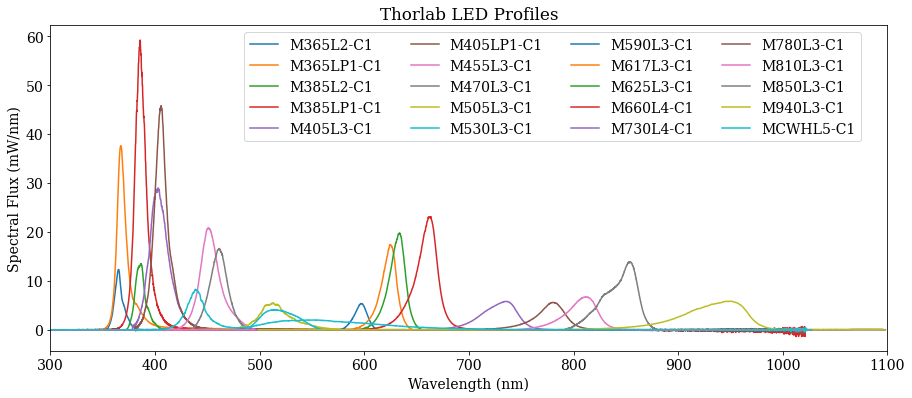

In [297]:
plt.figure(figsize=(15,6))
for led, data in led_source_dict.items():
    data = np.array(data)
    plt.plot(data[0], data[1], label=led)
    
plt.legend(loc='upper center',bbox_to_anchor=(0.6, 1),ncol=4)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Spectral Flux (mW/nm)")
plt.title("Thorlab LED Profiles")
plt.xlim(300, 1100)
plt.savefig('thorlabs_leds.png')

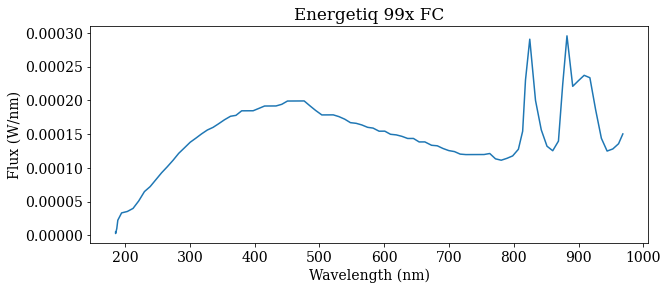

In [300]:
# Load Energetiq-99XFC profile output profile (no fiber)
# no actual profile, just guessing from the curve in the PDF file 

#curve assumes a 230um diameter fiber, 1m in length
# can use a 600µm fibre which then increases flux by a factor of ~2.25.
fiber_diameter_multiplier = 2.25
energetiq_fc = pd.read_csv('energetiq_99xfc.csv',header=None)
energetiq_fc.columns = ['Wavelength','flux_uW_nm']
energetiq_fc['flux_W_nm'] = energetiq_fc.flux_uW_nm*1e-6*fiber_diameter_multiplier

plt.figure(figsize=(10,4))
plt.plot(energetiq_fc.Wavelength, energetiq_fc.flux_W_nm)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Flux (W/nm)')
plt.title('Energetiq 99x FC')
plt.savefig('energetiq.png')

## Exposure Time Calculator

### Throughput

#### Calibration System Throughput

In [172]:
mask_tput = 0.3 # guess from Patrick, not sure exactly what this is
system_tput = 0.01/100. # from Ming/Zemax calculation at 660nm
total_tput = mask_tput * system_tput

In [173]:
# Remove filter dependence in model at 660 nm
r_filter = pd.read_csv(os.path.join(tput_dir, 'ideal_r.dat'),skiprows=4, delim_whitespace=True, names=['wave','transmission'])
r_filter_660 = float(r_filter[r_filter.wave == 660.]['transmission'])
filterless_tput = total_tput/r_filter_660

#### Filter Transmission

In [284]:
filter_bandpass = {}
filter_transmission = {}
for filter_name, lims in filter_info.items():
    filter_trans = pd.read_csv(os.path.join(tput_dir,'ideal_{}.dat'.format(filter_name)), delim_whitespace=True, skiprows=2,names=['Wavelength','Throughput'])
    
    # Smooth to find edges of filter - No longer doing this. Changes exp time by 0.1 seconds.
    min_trans = 0.01
    smoothed_filter_profile = np.convolve(filter_trans.Throughput, [0,1,1,1,0], mode='same')
    idx = np.sort(list(np.where(smoothed_filter_profile < min_trans)[0]))
    filter_bandpass_idx = set(range(idx[0], idx[-1])) - set(idx)
    
    filter_bandpass_ = filter_trans.Wavelength
    
    filter_transmission_ = scipy.interpolate.griddata(filter_trans.Wavelength, filter_trans.Throughput, filter_bandpass_, method='linear')
    filter_bandpass[filter_name] = filter_bandpass_
    filter_transmission[filter_name] = filter_transmission_

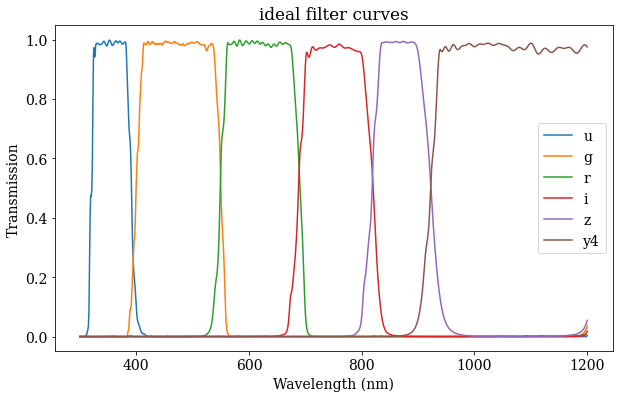

In [285]:
plt.figure(figsize=(10,6))
for filter_name, lims in filter_info.items():
    plt.plot(filter_bandpass[filter_name], filter_transmission[filter_name], label=filter_name)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transmission')
plt.title('ideal filter curves')
plt.legend()
plt.savefig('ideal_filters.png')

#### Camera Throughput

In [281]:
detector_efficiency = {}
# Detector efficiency
det_filename = os.path.join(tput_dir, 'detector_e2vPrototype.dat')
det_tput = pd.read_csv(det_filename, delim_whitespace=True, skiprows=5, names=['Wavelength','Throughput']) # wavelength [nm], Transmission

for filter_name, fb in filter_bandpass.items():
    #interpolate to filter_bandpass
    detector_eff = scipy.interpolate.griddata(det_tput.Wavelength, det_tput.Throughput, fb, method='linear')
    detector_efficiency[filter_name] = detector_eff

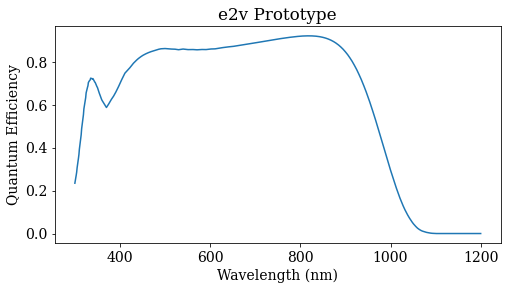

In [257]:
plt.figure(figsize=(8,4))
plt.plot(det_tput.Wavelength, det_tput.Throughput)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Quantum Efficiency')
plt.title('e2v Prototype')
plt.savefig('det_tput.png')

In [307]:
def get_integrated_count(wave_from_led, flux_from_led, test_wave, led): 
    try:

        photons_from_led = flux_from_led / (h*c/(test_wave*1e-9)) #convert W/nm to ph/sec/nm

        photons_on_focal_plane = photons_from_led * filterless_tput #multiply by throughput of calib optical system

        #put everything on the same grid (source, filter, detector)
        photons_on_filter = scipy.interpolate.griddata(wave_from_led, photons_on_focal_plane, filter_bandpass[filter_name], method='linear')

        #multiply by transmission of filters and detector
        count_rate = photons_on_filter * filter_transmission[filter_name] * detector_efficiency[filter_name] # ph/pix/s/nm     

        #divide by number of pixels to get ph/pix/sec/nm
        counts_per_pixel = count_rate/total_number_of_pixels

        #integrate over filter to get total ph/pix/sec
        integrated_ph_rate = simps(counts_per_pixel[~np.isnan(counts_per_pixel)], filter_bandpass[filter_name][~np.isnan(counts_per_pixel)])

        #SNR^2/photon count to get exposure time
        exp_time = required_exp_time(integrated_ph_rate)

        return led, filter_name, integrated_ph_rate, exp_time
    except:
        pass

## Results

In [325]:
# Get expected and required photons rates for Thorlabs LEDs
data = []
for led in leds:
    test_wave = None
    try:
        test_wave = int(led[1:4])
        
        for filter_name, lims in filter_info.items():
            if (test_wave > lims[0]) & (test_wave < lims[1]):
                flux_from_led = led_source_dict[led][1]/1000. #W/nm
                wave_from_led = led_source_dict[led][0] 
                led, filter_name, integrated_ph_rate, exp_time = get_integrated_count(wave_from_led, flux_from_led, test_wave, led)
                req_ph_rate, bandpass, wave_m, filter_ = required_photon_rate(test_wave,filter_name)
                req_exp_time = required_exp_time(req_ph_rate)
                
                data.append([led, filter_name, bandpass, integrated_ph_rate, req_ph_rate, exp_time, req_exp_time])                               
    except:
        print(led)

df = pd.DataFrame(np.vstack(data), columns=['LED','Filter','Bandpass (um)','Ph Rate (ph/pix/sec)','Req. Ph Rate','Exptime (s)','Req. Exptime (s)'])
df['Pass'] = False
for i, row in df.iterrows():
    if float(row['Exptime (s)']) < float(row['Req. Exptime (s)']):
        df.at[i, 'Pass'] = True

MCWHL5-C1


In [326]:
print(tabulate(df, headers = 'keys', tablefmt = 'psql'))

+----+------------+----------+-----------------+------------------------+----------------+---------------+--------------------+--------+
|    | LED        | Filter   |   Bandpass (um) |   Ph Rate (ph/pix/sec) |   Req. Ph Rate |   Exptime (s) |   Req. Exptime (s) | Pass   |
|----+------------+----------+-----------------+------------------------+----------------+---------------+--------------------+--------|
|  0 | M365L2-C1  | u        |           0.071 |                1243.92 |        7060.36 |      803.909  |           141.636  | False  |
|  1 | M365LP1-C1 | u        |           0.071 |                4743.25 |        7060.36 |      210.826  |           141.636  | False  |
|  2 | M385L2-C1  | u        |           0.071 |                1400.27 |        6345.87 |      714.148  |           157.583  | False  |
|  3 | M385LP1-C1 | u        |           0.071 |                6485.86 |        6345.87 |      154.182  |           157.583  | True   |
|  4 | M455L3-C1  | g        |           

In [328]:
e_data = []
for filter_name, lims in filter_info.items():
    test_wave = (lims[0] + lims[1])/2.
    flux_from_led = energetiq_fc.flux_W_nm
    wave_from_led = energetiq_fc.Wavelength
    led, filter_name, integrated_ph_rate, exp_time = get_integrated_count(wave_from_led, flux_from_led, test_wave, 'energetiq-99xfc@{}nm'.format(test_wave))
    req_ph_rate, bandpass, wave_m, filter_ = required_photon_rate(test_wave,filter_name)
    req_exp_time = required_exp_time(req_ph_rate)

    e_data.append([led, filter_name, integrated_ph_rate, req_ph_rate, exp_time, req_exp_time])                              

e_df = pd.DataFrame(np.vstack(e_data), columns=['LED','Filter','Ph Rate (ph/pix/sec)','Req. Ph Rate','Exptime (s)','Req. Exptime (s)'])
e_df['Pass'] = False
for i, row in e_df.iterrows():
    if float(row['Exptime (s)']) < float(row['Req. Exptime (s)']):
        e_df.at[i, 'Pass'] = True

In [329]:
print(tabulate(e_df, headers = 'keys', tablefmt = 'psql'))

+----+-------------------------+----------+------------------------+----------------+---------------+--------------------+--------+
|    | LED                     | Filter   |   Ph Rate (ph/pix/sec) |   Req. Ph Rate |   Exptime (s) |   Req. Exptime (s) | Pass   |
|----+-------------------------+----------+------------------------+----------------+---------------+--------------------+--------|
|  0 | energetiq-99xfc@359.5nm | u        |                135.908 |        7278.04 |       7357.94 |           137.4    | False  |
|  1 | energetiq-99xfc@478.5nm | g        |                526.756 |       11321.2  |       1898.41 |            88.3302 | False  |
|  2 | energetiq-99xfc@621.5nm | r        |                535.776 |        8241.93 |       1866.45 |           121.331  | False  |
|  3 | energetiq-99xfc@754.5nm | i        |                540.748 |        6202.97 |       1849.29 |           161.213  | False  |
|  4 | energetiq-99xfc@869.5nm | z        |                765.297 |        